In [1]:
datasetName = 'brain_V1_AllenBrainAtlas'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_V1_AllenBrainAtlas")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,SM-D9E6H_S81_E1-50,SM-D9E6H_S82_E1-50,SM-D9E6H_S83_E1-50,SM-D9E6H_S84_E1-50,SM-D9E6H_S85_E1-50
,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
SM-D9E6H_S81_E1-50,brain,VISp,L1,normal,H200.1030,M,19710
SM-D9E6H_S82_E1-50,brain,VISp,L1,normal,H200.1030,M,19710
SM-D9E6H_S83_E1-50,brain,VISp,L1,normal,H200.1030,M,19710
SM-D9E6H_S84_E1-50,brain,VISp,L1,normal,H200.1030,M,19710
SM-D9E6H_S85_E1-50,brain,VISp,L1,normal,H200.1030,M,19710


[1] NA NA NA NA NA

In [4]:
genes <- read.csv('human_VISp_2018-10-04_genes-rows.csv')
head(genes)

,gene,chromosome,entrez_id,gene_name,mouse_homologenes
,<fct>,<fct>,<int>,<fct>,<fct>
1,3.8-1.2,6,353007,HLA complex group 26 (non-protein coding) pseudogene,
2,3.8-1.3,6,353008,HLA complex group 26 (non-protein coding) pseudogene,
3,3.8-1.4,6,353009,HLA complex group 26 (non-protein coding) pseudogene,
4,3.8-1.5,6,353010,HLA complex group 26 (non-protein coding) pseudogene,
5,5-HT3C2,3,389180,"5-hydroxytryptamine (serotonin) receptor 3, family member E pseudogene",
6,A1BG,19,1,alpha-1-B glycoprotein,A1bg


In [5]:
row.names(data.matrix) <- as.character(genes$gene)
data.matrix[1:5, 1:5]

,SM-D9E6H_S81_E1-50,SM-D9E6H_S82_E1-50,SM-D9E6H_S83_E1-50,SM-D9E6H_S84_E1-50,SM-D9E6H_S85_E1-50
,<int>,<int>,<int>,<int>,<int>
3.8-1.2,0,0,0,0,0
3.8-1.3,0,0,0,0,0
3.8-1.4,0,0,0,0,0
3.8-1.5,0,0,0,0,0
5-HT3C2,0,0,0,0,0


In [6]:
# Pre-processing
min.cells = 3
min.features = 200
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

In [7]:
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = '^MT-')
# dataobj <- subset(dataobj, subset = nFeature_RNA > 200)
# dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [8]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 4000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [9]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  ST18, NCKAP5, CERCAM, PLP1, ENPP2, DOCK5, MOG, PTGDS, RNF220, CARNS1 
	   UGT8, BCAS1, CNDP1, MOBP, C10orf90, LOC101927967, FRMD4B, QKI, LOC101929249, SLC5A11 
	   COL4A5, LOC101927459, TMEM63A, CLDN11, FA2H, MYRF, SHROOM4, DOCK10, CDK18, ABCA8 
Negative:  CNTN5, VSNL1, ASIC2, PPARGC1A, GRIK2, CCK, MGAT4C, DPP10, LRRTM4, TRHDE 
	   FAM19A1, KIAA1217, PCP4, GRIP1, HS3ST4, LOC105373893, FRAS1, ZNF804B, NTNG1, SGCZ 
	   TRPC3, TESPA1, PHACTR2, PDZRN4, LRRC4C, RORB, NWD2, SCG2, FGF13, IL1RAPL2 
PC_ 2 
Positive:  MOBP, MOG, CERCAM, ST18, PLP1, CARNS1, SLC44A1, ENPP2, CNTN2, LOC101929249 
	   MBP, LOC101927459, QDPR, CNDP1, CLDN11, MYRF, PLCL1, CLDND1, UGT8, FOLH1 
	   TF, ABCA8, LOC101927967, PLEKHH1, LDB3, OPALIN, MAG, SLC5A11, RNASE1, PXK 
Negative:  C10orf11, DOCK8, APBB1IP, ARHGAP24, LPAR6, SLC1A3, CSF1R, TBXAS1, FYB, LYN 
	   NHSL1, CX3CR1, TNS3, SYK, BLNK, C3, ARHGAP15, CST3, LOC105378305, ABCC4 
	   MAML2, CHST11, ADAM28, INPP5D, ATP8B4, CSF3R, RNF219-AS1, COL5A3, L

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


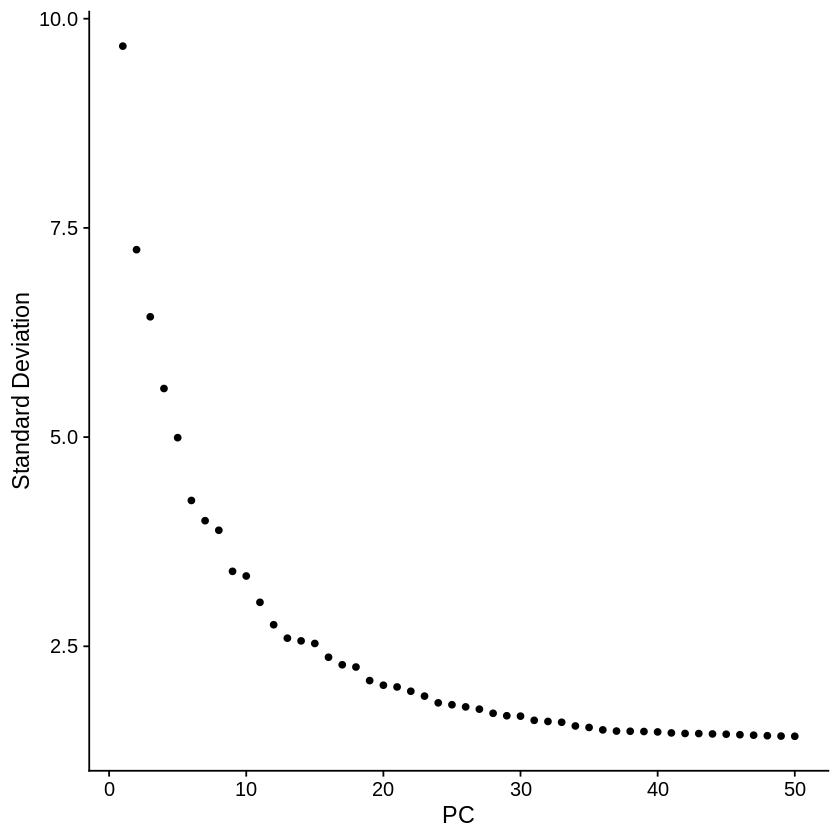

In [10]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [11]:
dev.off()
pcDim = 20 # set as 75 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
05:15:20 UMAP embedding parameters a = 0.9922 b = 1.112

05:15:20 Read 8998 rows and found 20 numeric columns

05:15:20 Using Annoy for neighbor search, n_neighbors = 30

05:15:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

05:15:21 Writing NN index file to temp file /tmp/RtmpWd6jsL/file796f2d6f30e3

05:15:21 Searching Annoy index using 1 thread, search_k = 3000

05:15:24 Annoy recall = 100%

05:15:24 Commencing smooth kNN distance calibration using 1 thread

05:15:25 Initializing fr

In [12]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8998
Number of edges: 334461

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9315
Number of communities: 21
Elapsed time: 0 seconds


05:15:49 UMAP embedding parameters a = 0.9922 b = 1.112

05:15:49 Read 8998 rows and found 20 numeric columns

05:15:49 Using Annoy for neighbor search, n_neighbors = 30

05:15:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

05:15:51 Writing NN index file to temp file /tmp/RtmpWd6jsL/file796f6665bf02

05:15:51 Searching Annoy index using 1 thread, search_k = 3000

05:15:53 Annoy recall = 100%

05:15:53 Commencing smooth kNN distance calibration using 1 thread

05:15:54 Initializing from normalized Laplacian + noise

05:15:56 Commencing optimization for 500 epochs, with 381046 positive edges

05:16:17 Optimization finished



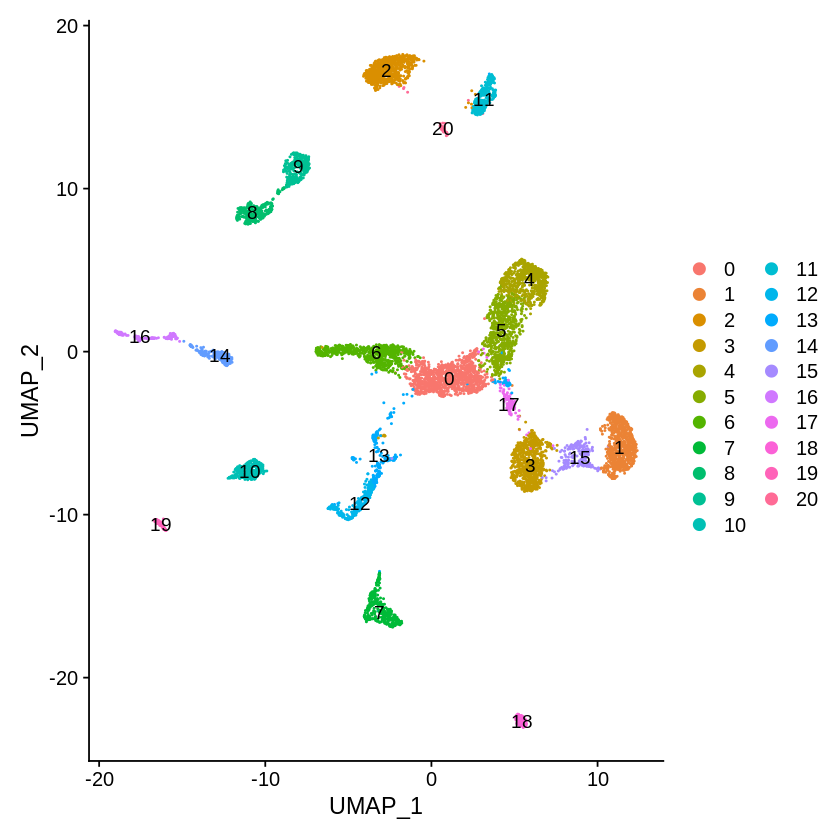

In [13]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [14]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

In [27]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20



In [16]:
new.cluster.ids <- c('Brain-Nerve tissue-Excitatory neuron-SLC17A6', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Excitatory neuron-GRM5',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Excitatory neuron-CAMK2A', 'Brain-Nerve tissue-Excitatory neuron-CAMK2A',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A6', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Nerve tissue-Inhibitory neuron-GAD1',
                    'Brain-Nerve tissue-PV Inhibitory neuron-PVALB', 'Brain-Nerve tissue-Excitatory neuron-THEMIS', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Astrocyte-AQP4', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Nerve tissue-VIP Inhibitory neuron-VIP',
                    'Brain-Nerve tissue-Excitatory neuron-SLC17A7', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Excitatory neuron-SLC17A7',
                    'Brain-Nerve tissue-Microglia-CX3CR1', 'Brain-Nerve tissue-Oligodendrocyte precursor cell-OLIG2 and OLIG1', 'Brain-Nerve tissue-Excitatory neuron-FEZF2')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

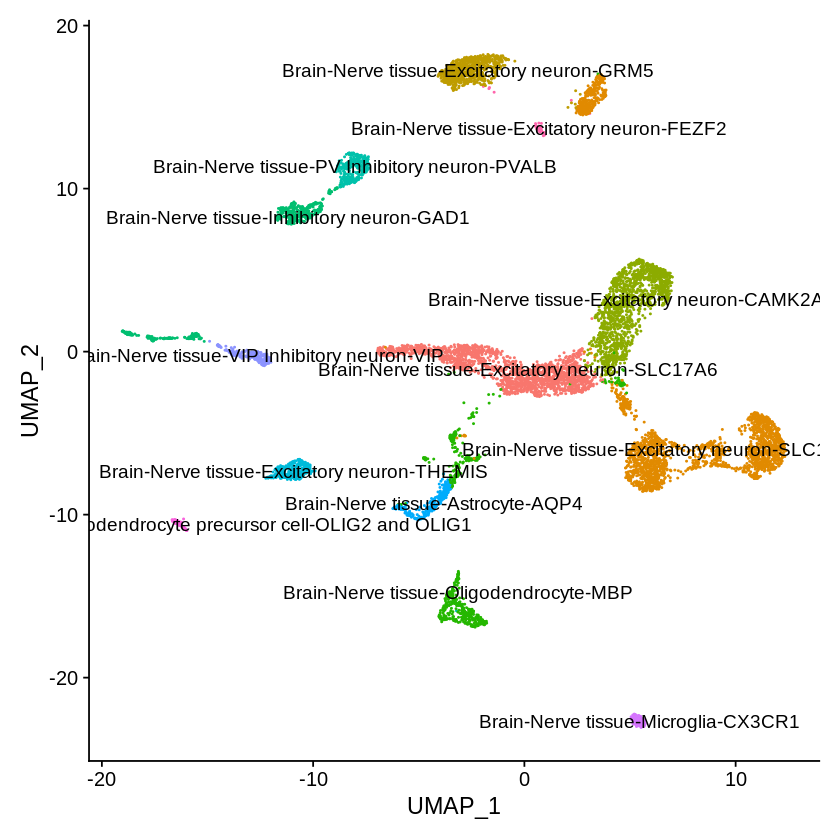

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [ ]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))